# Quick Start - Above Ground Biomass - Species-agnostic

## Overview

This notebook walks us through making a request to Above Ground Biomass (AGB) Geospatial APIs for Species agnostic Data Layer and analyzing the results through visualizations.

Above Ground Biomass (AGB) Geospatial APIs are exclusively available in API version <I>v4</I>, distinguishing it from the v3 version.

Geospatial APIs - Above Ground Biomass (AGB) supports both historical carbon units retrieval and prediction of the same based on the available data. Let's say the user requests information for 2023 and 2024, of which the system has data for 2023 alone and doesn't pertain the 2024's data, instead of not retrieving anything, the system predicts the 2024's information relying on 2023's data for reference.The primary use case is calculating historic and future carbon units based on a species-agnostic Data Layer that is able to generate baseline and predictive results. The Above Ground Biomass (AGB) Species agnostic Data Layer provides historic and future (predictive) carbon units and CO2 capture data without any dependency on a specific species.

For future predictions in the example below, the predictive models use the Coupled Model Intercomparison Project Phase 6 (CMIP6) – climate change patterns data and ISRIC Soil Grid data. 

<b>The Above Ground Biomass (AGB) Data Set currently has spatial coverage for Brazil in the temporal range from 2015 to 2100.</b>

### Setup

Before starting, you have to install IBM EI Geospatial python SDK using `pip3 install -U ibmpairs` and the folium module ,specifically needed for this sample using `pip3 install folium`.

<b>Note:</b> To run this notebook seamlessly, you have to first configure your Geospatial APIs' credentials in a file named `secrets.ini` in the below format:

```
[EI]
api.api_key = <Your Geospatial APIs API key>
api.tenant_id = <Your Geospatial APIs Tenant ID>
api.org_id = <Your Geospatial APIs Org ID>

```
Keep the secrets.ini file at an appropriate relative location of this notebook. For example, as specified in the below config.

```config.read('../../auth/secrets.ini')```

In [ ]:
!pip install ibmpairs
!pip install rasterio
!pip install folium

In [36]:
import ibmpairs.client as client
import ibmpairs.query as query
import matplotlib.pyplot as plt
import os
import json
import rasterio
from IPython.display import display as display_summary
from IPython import display
import configparser
import folium,numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import branca.colormap as cm
import pandas as pd

Now, let's create a client object using the API_KEY, TENANT_ID (or CLIENT_ID) and ORG_ID to create an authenticated HTTP client Authentication token using 'ibmpairs.client' module, to use it in the subsequent steps.

In [37]:
config = configparser.RawConfigParser()
config.read('../../auth/secrets.ini')

EI_ORG_ID     = config.get('EI', 'api.org_id') 
EI_TENANT_ID  = config.get('EI', 'api.tenant_id') 
EI_APIKEY     = config.get('EI', 'api.api_key')

EI_client_v4 = client.get_client(org_id    = EI_ORG_ID,
                                  tenant_id = EI_TENANT_ID,
                                  api_key     = EI_APIKEY,
                                  version   = 4
                                )

2024-06-25 16:35:19 - paw - INFO - The client authentication method is assumed to be OAuth2.
2024-06-25 16:35:19 - paw - INFO - Legacy Environment is False
2024-06-25 16:35:19 - paw - INFO - The authentication api key type is assumed to be IBM EIS, because the api key prefix 'PHX' is present.
2024-06-25 16:35:22 - paw - INFO - Authentication success.
2024-06-25 16:35:22 - paw - INFO - HOST: https://api.ibm.com/geospatial/run/na/core/v4


The following code snippet submits the query for the AGB Data Layer <i>above-ground-biomass</i>  for years 2020, 2021, 2022, 2023 and 2024 using Geospatial APIs V4 query API, waits for it to finish, downloads the data to the download folder, loads the data to memory and displays it on screen. This could take a few minutes to complete as all the data is brought together.

Let's go ahead, define and submit a query.

In [38]:
# submit, checks the status and downloads the result of the query (this will poll until the result is ready)
species_agnostic_query_object = query.submit_check_status_and_download({ 
                          "name": "Above Ground Biomass - Species agnostic",
                          "spatial": {
                            "geojson": {
                                  "type": "Feature",
                                  "geometry": {
                                  "type":"MultiPolygon",
                                  "coordinates": [[[[-60.21431545474348,-2.9969556285713685],
                                                    [-60.16860892246131,-2.8849294291782206],
                                                    [-60.11175970438557,-2.8799162485848604],
                                                    [-60.086932992294685,-2.9799697319842102],
                                                    [-60.21431545474348,-2.9969556285713685]]]] 
                                  }   
                            } },
                          "temporal": { "years": [2020, 2021, 2022, 2023, 2024] },
                          "layers": [ { "datalayer": "above-ground-biomass" } ]
                        },EI_client_v4)

2024-06-25 16:35:22 - paw - INFO - TASK: submit_check_status_and_download STARTING.
2024-06-25 16:35:23 - paw - INFO - The query was successfully submitted with the id: 1719273600_39923200.
2024-06-25 16:35:24 - paw - INFO - The query 1719273600_39923200 has the status Queued.
2024-06-25 16:35:55 - paw - INFO - The query 1719273600_39923200 has the status Running.
2024-06-25 16:36:26 - paw - INFO - The query 1719273600_39923200 has the status Running.
2024-06-25 16:36:57 - paw - INFO - The query 1719273600_39923200 has the status Running.
2024-06-25 16:37:28 - paw - INFO - The query 1719273600_39923200 has the status Running.
2024-06-25 16:37:59 - paw - INFO - The query 1719273600_39923200 has the status Running.
2024-06-25 16:38:31 - paw - INFO - The query 1719273600_39923200 has the status Running.
2024-06-25 16:39:02 - paw - INFO - The query 1719273600_39923200 has the status Succeeded.
2024-06-25 16:39:02 - paw - INFO - The query 1719273600_39923200 was successful after checking th

<b>Note:</b> Let's start with some utility functions that we are going to use through out this notebook, which is not a necessity but are good to use functions that we are defining to enrich user experience through this notebook.

In [39]:
# Removing the max col width on the table to display the entire data.
pd.set_option('display.max_colwidth', None)


Let's look at the summary from the result of the query:

In [40]:
species_agnostic_file_list = species_agnostic_query_object.list_files()
#This gets the folder location of where the query result is downloaded.
download_location = species_agnostic_query_object.get_download_folder() + species_agnostic_query_object.id
summary_file = download_location + '/' +'Above Ground Biomass-above ground biomass summary agb.json'

summary = pd.read_json(summary_file)
display_summary(summary)

,year,layer_name,area_in_ha,baseline_agb_min_units,baseline_agb_max_units,baseline_agb_mean_units,baseline_total_agb_units,baseline_total_carbon_tons,baseline_total_co2_tons,agb_analytics_type,predicted_total_agb_units,predicted_total_carbon_tons,predicted_total_co2_tons
0,2020,above-ground-biomass,11867.015873,0.9,25.38,12.594440,1742806.08,871403.04,3.198049e+06,historical,NaN,NaN,NaN
1,2021,above-ground-biomass,11867.015873,0.9,25.38,13.255119,1834190.28,917095.14,3.365739e+06,historical,NaN,NaN,NaN
2,2022,above-ground-biomass,11867.015873,0.9,25.02,12.716778,1759735.08,879867.54,3.229114e+06,historical,NaN,NaN,NaN
3,2023,above-ground-biomass,11867.015873,0.9,22.95,12.222782,1691376.30,845688.15,3.103676e+06,historical,NaN,NaN,NaN
4,2024,above-ground-biomass,11867.015873,NaN,NaN,NaN,NaN,NaN,NaN,prediction,1.724768e+06,862383.903099,3.164949e+06


Let's define some utility functions to plot the downloaded raster tiff and the summary files.

In [41]:
def get_extent(f):
    with open(f, 'r') as ff:
        stats = json.load(ff)
    boundingBox=stats["boundingBox"]
    myextent = [boundingBox["minLongitude"],boundingBox["maxLongitude"],boundingBox["minLatitude"],boundingBox["maxLatitude" ] ]
    return myextent


def display_raster(raster_file_name, colorMap, title = None, Max=None, Min=None, myextent=None):
    if raster_file_name.endswith('.tiff'):
        with rasterio.open(raster_file_name) as raster_file:
            if not myextent:
                myextent=get_extent(raster_file_name+".json")
            data = raster_file.read(1)
            mask = (data == -9999)
            masked_data = np.ma.masked_array(data, mask)
            plt.figure(figsize = (20, 12))
            if Max is None:
                Max=masked_data.max()
            if Min is None:
                Min = masked_data.min()
            plt.imshow(masked_data, cmap = colorMap, vmin = Min, vmax = Max,extent = myextent)
            if not title:
                title=os.path.basename(raster_file_name)
            plt.title(title)
            plt.colorbar()
            plt.show()
  

Let's display the resulting raster tiff file(s) and the summary file(s) using the above methods.

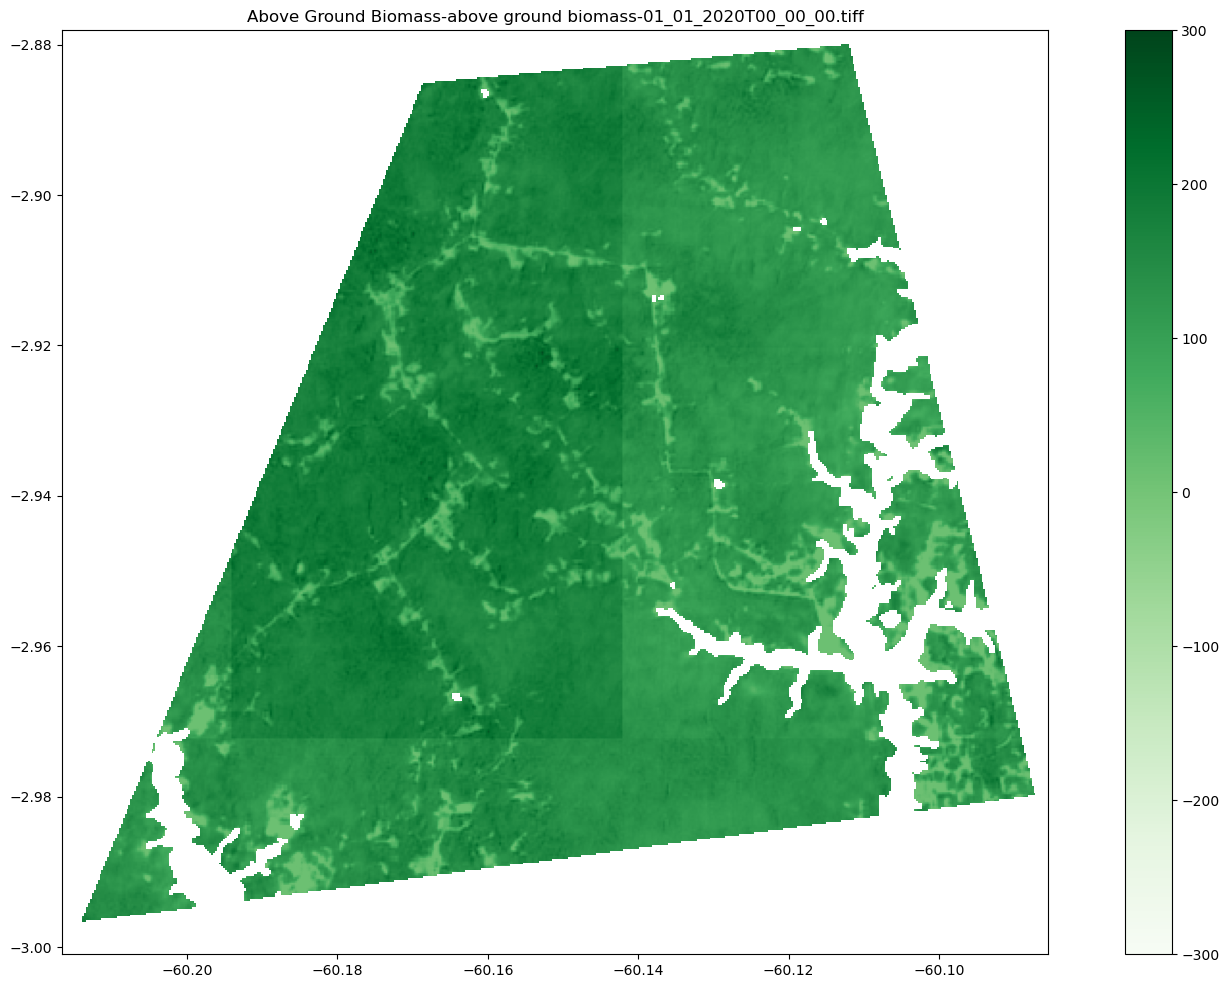

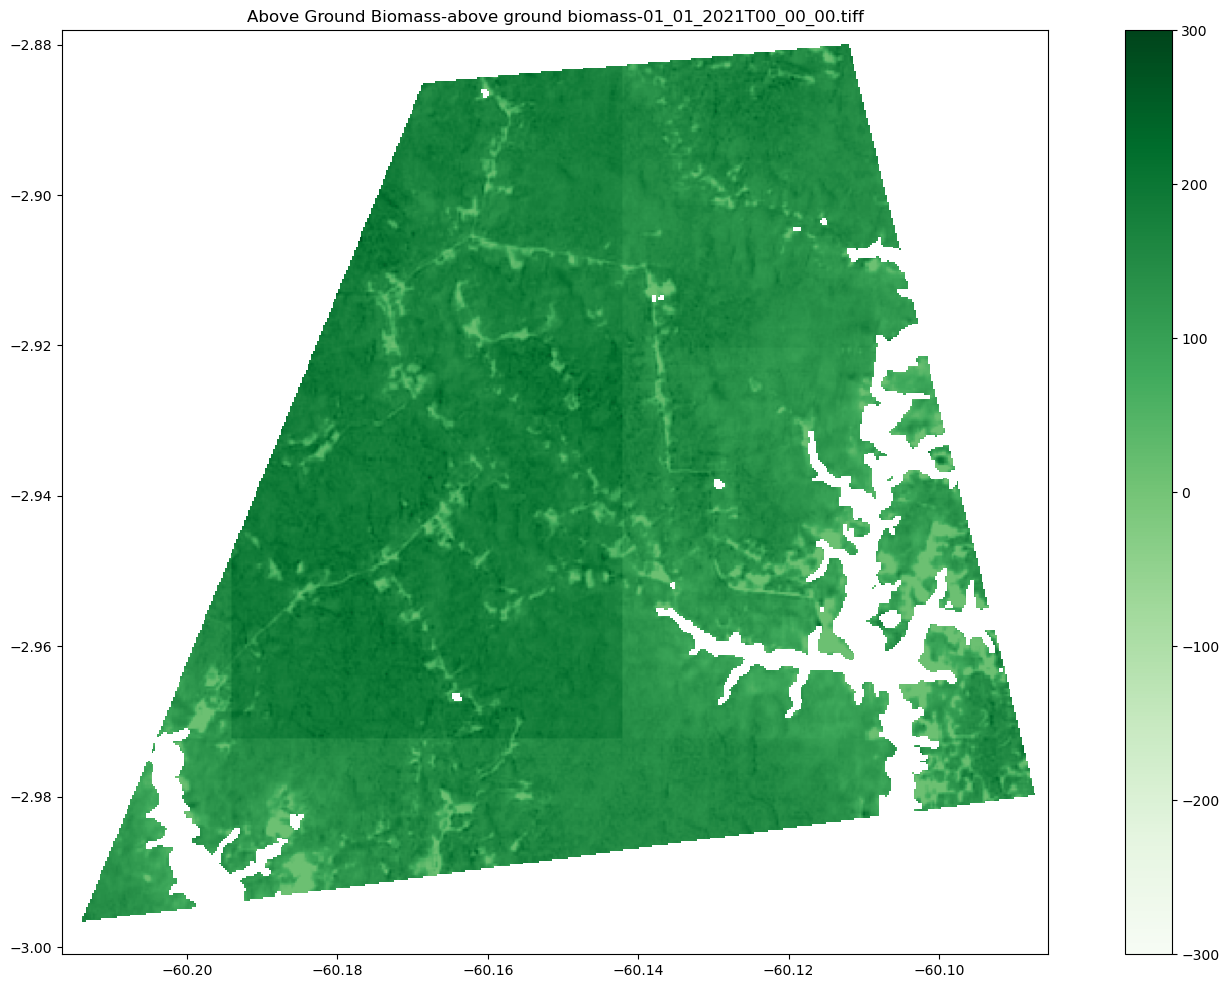

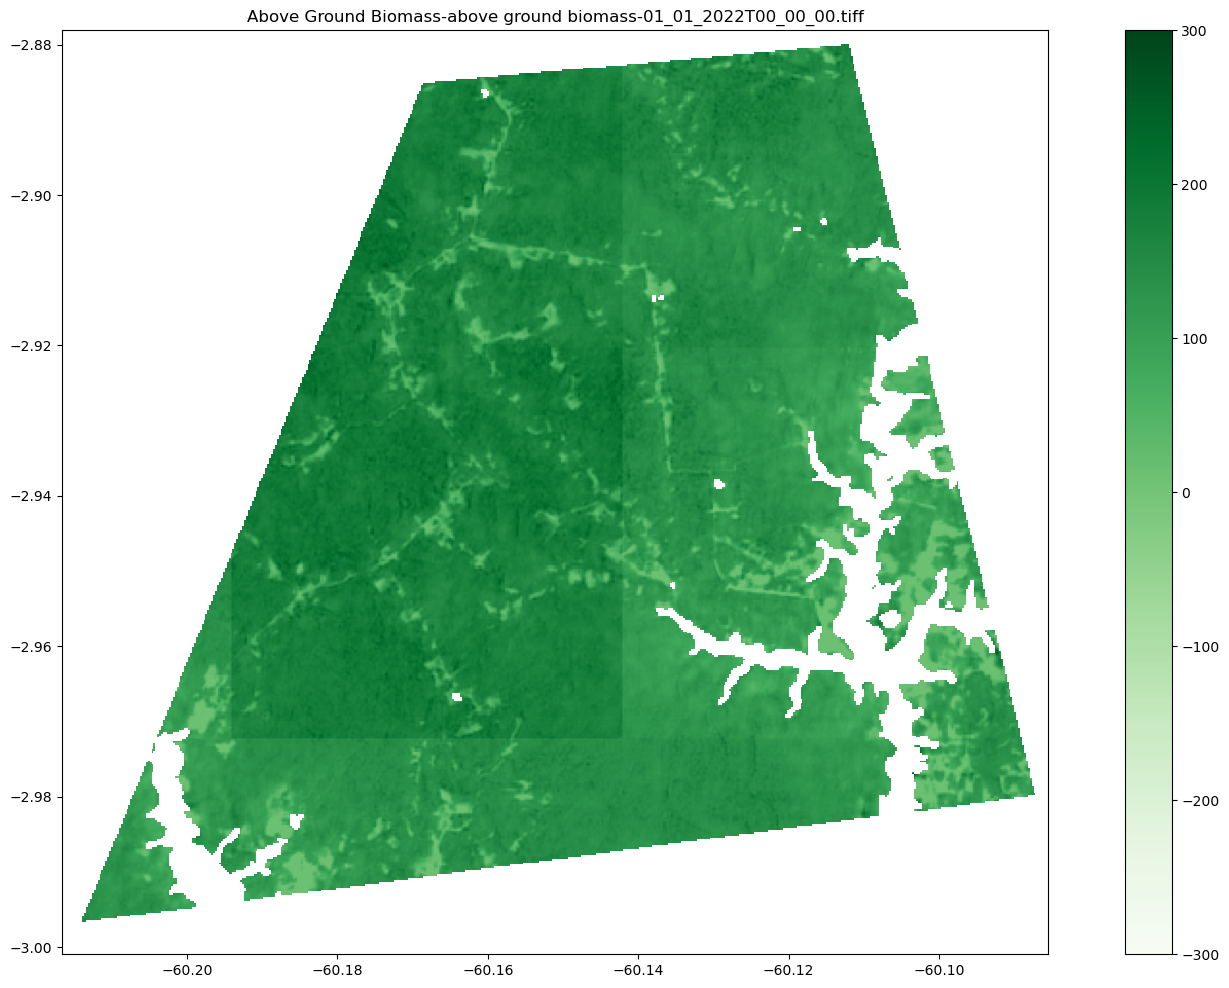

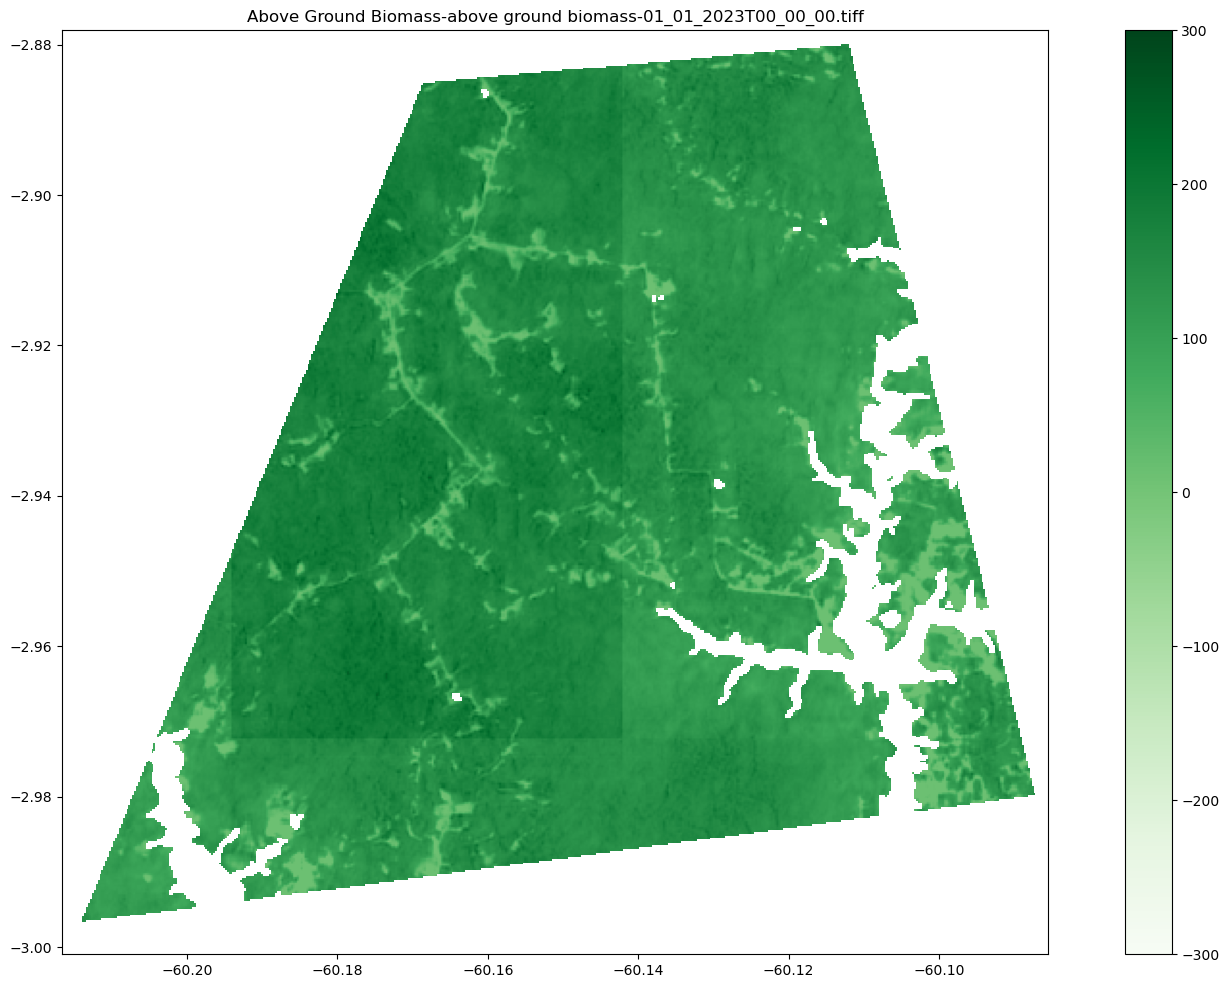

In [42]:
#sorting all the files in order from 2020 to 2023
species_agnostic_file_list.sort()
for f in species_agnostic_file_list:
    if f.endswith('.tiff'):
        display_raster(f, 'Greens', Min=-300, Max=300)  #-100 is water

### Understanding the sample:

<b>Code:</b>

Let's go over the details of the above example, 

The above code snippet is run using Geospatial APIs V4 query API to retrieve carbon units and CO2 capture for:

* A specific area which is a Multipolygon defined as a standard Geojson format for the spatial data.

* The temporal intevals' timestamp as years. In this example, we are passing the years from 2020 to 2024 as the years. Years from 2020 to 2023 are historical baseline years while 2024 is a prediction year. Note that any years beyond the current year are prediction years.

Submitting the query above does not immediately return data because the raster area query takes time and its operation is asynchronous. In this case we use `query.submit()`. This submits the query to Geospatial APIs V4 query API. Once the query is submitted, we use `download()` method that checks the status of the query as it runs and, once complete, downloads the results of the query as a zip file.

You can see from the output of the call that that `species_agnostic_query_object.download()` prints the status of the job as it progresses.

On the first line of the log, you can see the query Id that has been assigned by Geospatial APIs to the query job which looks something like "1718236800_23593521" and is unique for each query submitted. After this, you can see the query transistion through Queued, Initializing, Running and finally succeeded. You won't necessarily see all of these stages printed out depending on how busy the Geospatial APIs system is at the time you submit.

Once the processing is complete you can see that the resulting query zip file is placed in the download folder. This folder is usually placed inside the directory where you run this notebook from.

<b>Output:</b>

The library will automatically unzip this zip file for you and into a directory named after the query Id. In this case the contents are as follows:


- Above Ground Biomass-above ground biomass summary agb.json
- Above Ground Biomass-above ground biomass-01_01_2020T00_00_00.tiff
- Above Ground Biomass-above ground biomass-01_01_2023T00_00_00.tiff
- Above Ground Biomass-above ground biomass-01_01_2022T00_00_00.tiff
- Above Ground Biomass-above ground biomass-01_01_2021T00_00_00.tiff
- Above Ground Biomass-above ground biomass-01_01_2023T00_00_00.tiff.json
- Above Ground Biomass-above ground biomass-01_01_2020T00_00_00.tiff.json
- Above Ground Biomass-above ground biomass-01_01_2021T00_00_00.tiff.json
- Above Ground Biomass-above ground biomass-01_01_2022T00_00_00.tiff.json
- data_acknowledgement.txt
- output.info


The `Above Ground Biomass-above ground biomass summary agb.json` file gives you a brief about the information retrieved from each year specified in the query.

As you can see the summary json file gives the agb units, carbon units and CO2 capture of historical and predicted years. It also provides the area in hectares, baseline agb min, max, mean and total units for the Data Layer <i>above-ground-biomass</i>.

``` json
[
    {
        "year": 2020,
        "layer_name": "above-ground-biomass",
        "area_in_ha": 470369.65947,
        "baseline_agb_min_units": 0.9,
        "baseline_agb_max_units": 51.3,
        "baseline_agb_mean_units": 11.878334,
        "baseline_total_agb_units": 62044456.32,
        "baseline_total_carbon_tons": 31022228.16,
        "baseline_total_co2_tons": 113851577.3472,
        "agb_analytics_type": "historical"
    },
    {
        "year": 2021,
        "layer_name": "above-ground-biomass",
        "area_in_ha": 470369.65947,
        "baseline_agb_min_units": 0.9,
        "baseline_agb_max_units": 41.58,
        "baseline_agb_mean_units": 12.975094,
        "baseline_total_agb_units": 67761699.84,
        "baseline_total_carbon_tons": 33880849.92,
        "baseline_total_co2_tons": 124342719.2064,
        "agb_analytics_type": "historical"
    },
    {
        "year": 2022,
        "layer_name": "above-ground-biomass",
        "area_in_ha": 470369.65947,
        "baseline_agb_min_units": 0.9,
        "baseline_agb_max_units": 41.13,
        "baseline_agb_mean_units": 12.885414,
        "baseline_total_agb_units": 67304759.04,
        "baseline_total_carbon_tons": 33652379.52,
        "baseline_total_co2_tons": 123504232.8384,
        "agb_analytics_type": "historical"
    },
    {
        "year": 2023,
        "layer_name": "above-ground-biomass",
        "area_in_ha": 470369.65947,
        "baseline_agb_min_units": 0.9,
        "baseline_agb_max_units": 30.06,
        "baseline_agb_mean_units": 12.141811,
        "baseline_total_agb_units": 63420687.36,
        "baseline_total_carbon_tons": 31710343.68,
        "baseline_total_co2_tons": 116376961.3056,
        "agb_analytics_type": "historical"
    },
    {
        "year": 2024,
        "layer_name": "above-ground-biomass",
        "area_in_ha": 470369.65947,
        "predicted_total_agb_units": 64720419.243173,
        "predicted_total_carbon_tons": 32360209.621586,
        "predicted_total_co2_tons": 118761969.311222,
        "agb_analytics_type": "prediction"
    }
]
```


The .tiff.json files hold metadata about the raster tiff images like the information about pixel and raster image statistics. For example:
``` json
{
    "pixelType": "fl",
    "pixelNoDataVal": -9999,
    "spatialRef": "EPSG:4326",
    "boundingBox": {
        "minLatitude": -3.271296,
        "maxLatitude": -2.271872,
        "minLongitude": -60.388608,
        "maxLongitude": -59.7824
    },
    "pixelDimensions": {
        "pixelSizeDegreeLatitude": 0.000256,
        "pixelSizeDegreeLongitude": 0.000256,
        "numberPixelsLatitude": 3904,
        "numberPixelsLongitude": 2368
    },
    "rasterStatistics": {
        "pixelMin": 10.0,
        "pixelMax": 570.0,
        "pixelCount": 9244672,
        "pixelMean": 131.978851,
        "pixelStandardDeviation": 55.44213
    },
    "agbAnalytics": {
        "area_in_ha": 470369.65947,
        "baseline_agb_min_units": 0.9,
        "baseline_agb_max_units": 51.3,
        "baseline_agb_mean_units": 11.878334,
        "baseline_total_agb_units": 62044456.32,
        "baseline_total_carbon_tons": 31022228.16,
        "baseline_total_co2_tons": 113851577.3472
    }
}
```



The `data_acknowledgement.txt` file contains acknowledgements associated with the data we provide. 

The `output.info` file maps the images files back to the Geospatial APIs data layers that were used to produce them:

``` json
{
	"files": [
		{
			"name": "Above Ground Biomass-above ground biomass-01_01_2023T00_00_00",
			"datalayerId": "38000",
			"datalayerName": "above ground biomass",
			"timestamp": 1672531200000,
			"layerType": "raster"
		},
		{
			"name": "Above Ground Biomass-above ground biomass-01_01_2022T00_00_00",
			"datalayerId": "38000",
			"datalayerName": "above ground biomass",
			"timestamp": 1640995200000,
			"layerType": "raster"
		},
		{
			"name": "Above Ground Biomass-above ground biomass-01_01_2020T00_00_00",
			"datalayerId": "38000",
			"datalayerName": "above ground biomass",
			"timestamp": 1577836800000,
			"layerType": "raster"
		},
		{
			"name": "Above Ground Biomass-above ground biomass-01_01_2021T00_00_00",
			"datalayerId": "38000",
			"datalayerName": "above ground biomass",
			"timestamp": 1609459200000,
			"layerType": "raster"
		}
	]
}
```



The result is displayed in two forms: 
- The first one is a table that presents the data of each year into different rows. If we observe the table, the data is presented in such a way that the historical information is put first and the predicted information is put later to give the user an understanding of how the agab cover has increased over the years and how it is predicted based on the available historical infomartion.
- The second one is the raster tiff file plotted on the coordinate system. 



There are many other ways you can visualize and understand the data that's been retrieved, for example:

We can draw a combined line chart with the available data from both baseline and predicted information 


Combined agb units, total carbon tons and CO2 tons for Species agnostic


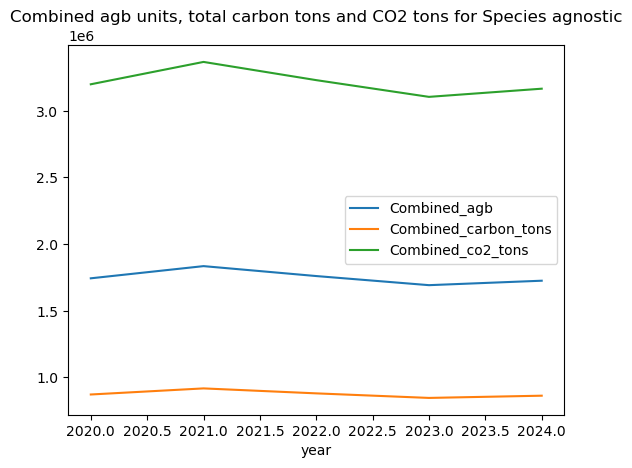

,Combined_agb,Combined_carbon_tons,Combined_co2_tons
year,,,
2020,1.742806e+06,871403.040000,3.198049e+06
2021,1.834190e+06,917095.140000,3.365739e+06
2022,1.759735e+06,879867.540000,3.229114e+06
2023,1.691376e+06,845688.150000,3.103676e+06
2024,1.724768e+06,862383.903099,3.164949e+06


In [43]:
agb_predictions_title='Combined agb units, total carbon tons and CO2 tons for Species agnostic'
combined_df = pd.DataFrame(summary[['year', 'baseline_total_agb_units','baseline_total_carbon_tons','baseline_total_co2_tons','predicted_total_agb_units','predicted_total_carbon_tons','predicted_total_co2_tons']]).set_index('year')
plot_pcombined_df=pd.DataFrame()
plot_pcombined_df['Combined_agb'] = combined_df['baseline_total_agb_units'].fillna(0) + combined_df['predicted_total_agb_units'].fillna(0)
plot_pcombined_df['Combined_carbon_tons'] = combined_df['baseline_total_carbon_tons'].fillna(0) + combined_df['predicted_total_carbon_tons'].fillna(0)
plot_pcombined_df['Combined_co2_tons'] = combined_df['baseline_total_co2_tons'].fillna(0) + combined_df['predicted_total_co2_tons'].fillna(0)
g = plot_pcombined_df.plot.line(title=agb_predictions_title)
print(agb_predictions_title)
plt.show()
plot_pcombined_df

Below is the code snippet to overlay the tiff on a world map to get an interactive visual display, after which we display the screenshot of the same for ease of rendering the notebook

In [ ]:
#For visualizing maps
def create_fast_colormap_for_range(mycmmap_choice,vmin,vmax, empty_val):
    cm = mycmmap_choice.scale(vmin,vmax)   # cm.linear.Spectral_07.scale(0, 20)  # .to_step(1)   
    cmArray = []
    for i in range(vmin, vmax, 1):
        if i> vmax or i< vmin or  i == empty_val:   # i>20 or i==0:
            cmArray.insert(i,(1, 0, 0, 0)) 
        else:
            cmArray.insert(i,colors.to_rgba(cm(i), 0.8)) 
    return cmArray
cmArray = create_fast_colormap_for_range(cm.linear.Greens_09, 10, 282, 0) #cm.linear.Spectral_07.scale(0,20)
for file in species_agnostic_file_list:
    if file.endswith('.tiff'):
        with rasterio.open(file) as raster:
            # Display the boundaries of the raster image for a visual check
            rb = raster.bounds
            map = folium.Map( max_bounds=True,
                    location=[(rb.bottom+rb.top)/2, (rb.left+rb.right)/2],   # [40.8768,-73.6195],
                    zoom_start=12,
                    min_lat=rb.bottom, # min_lat,
                    max_lat=rb.top,    # max_lat,
                    min_lon=rb.left,   # min_lon,
                    max_lon=rb.right   #max_lon 
                    )
            data = raster.read(1)
            data[data==-9999] = np.nan_to_num(np.nan)
            data[data==0] = np.nan_to_num(np.nan)
            folium.raster_layers.ImageOverlay(
                        image=data.astype(np.uint8),opacity=0.7, 
                        colormap=lambda value: cmArray[value],
                        bounds=[[rb.bottom, rb.left], [rb.top, rb.right]]
                    ).add_to(map)
            map.add_child(cm.linear.Greens_09.scale(10, 282))
map

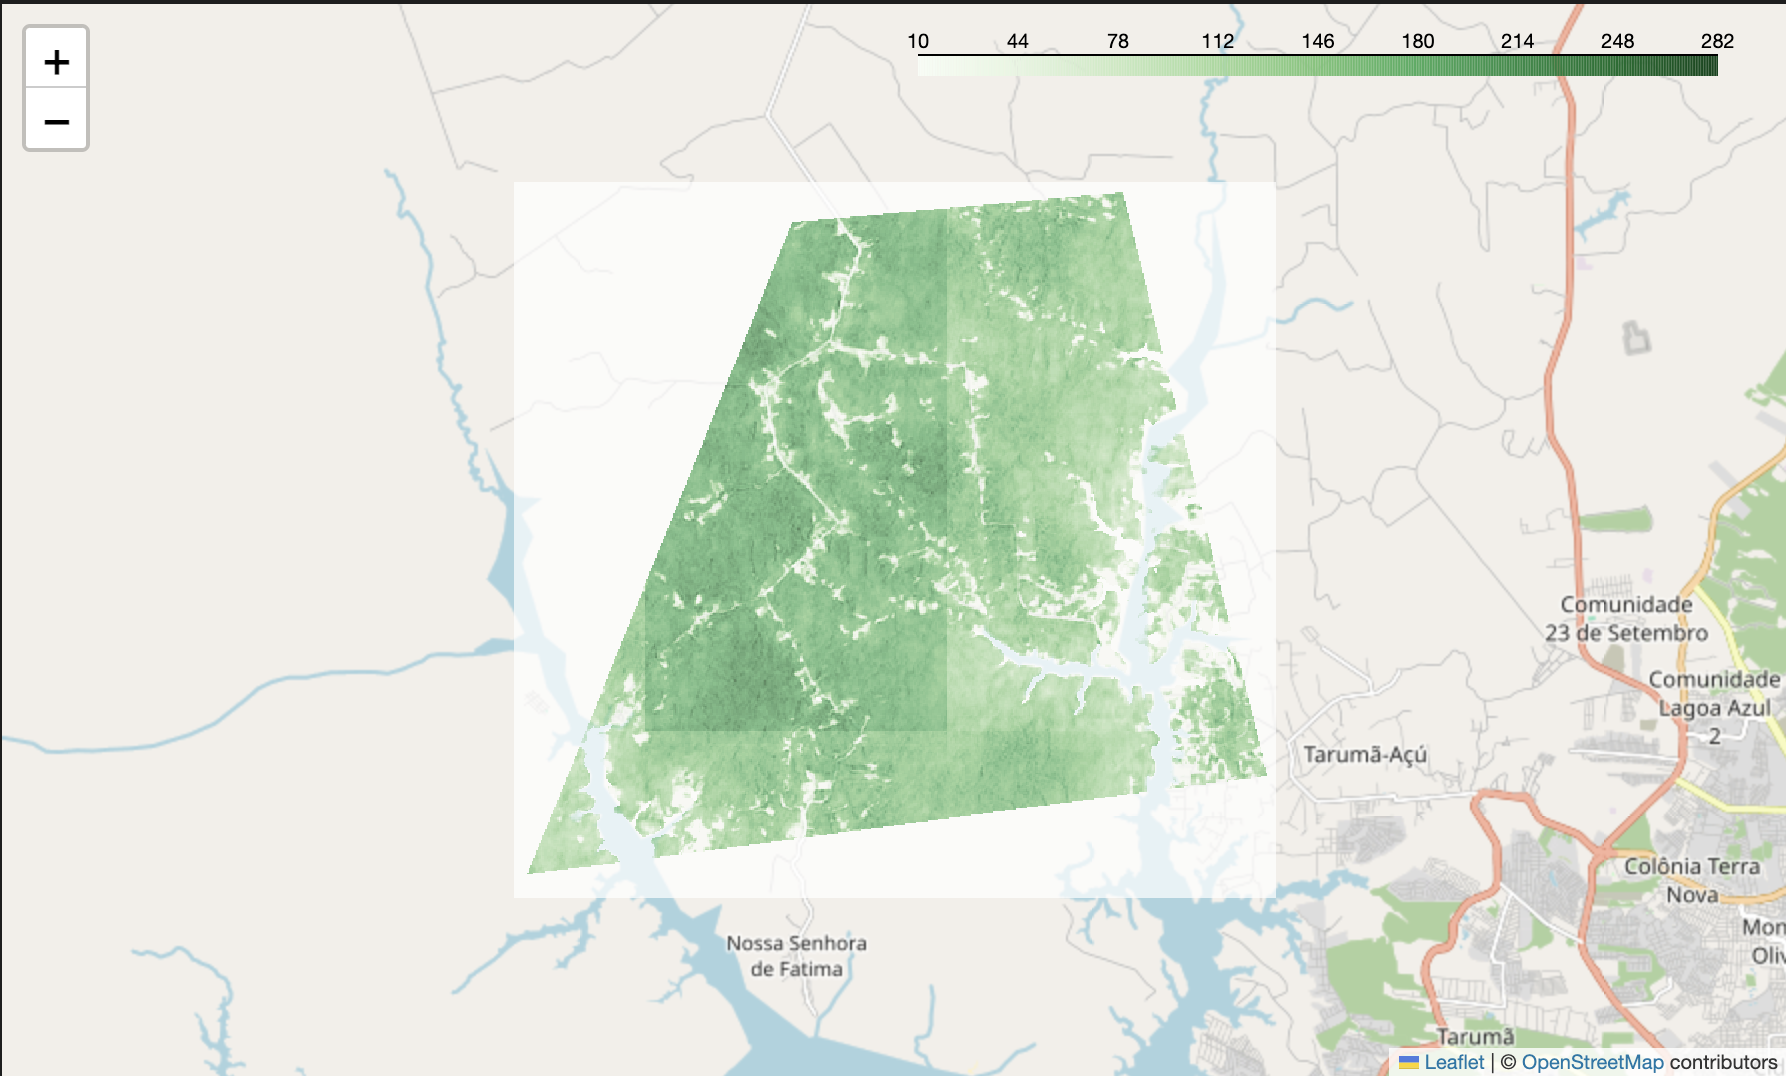

In [46]:
display.Image('agb_species_agnostic.png')